# Imports

### Python

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import scipy.stats as stats

pd.set_option("display.max_rows",101)
import feather
import pickle
import datetime as dt


# Models =========================================
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.random_projection import GaussianRandomProjection as GRM

from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import TruncatedSVD


from sklearn.ensemble import RandomForestRegressor as PythonRF_Regressor
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
# ===============================================

import  matplotlib.pyplot as plt

# In this notebook

###  - XGBoost, RandomForest along with Feature Engineering are used for Kaggle Competetion: Santander Value Prediction 

### Spark

In [478]:
from pyspark.sql import SparkSession, Row

import pyspark.sql.functions as fcn 
from pyspark.sql.functions import pandas_udf, PandasUDFType, col
from pyspark.sql.types import IntegerType, StringType, TimestampType
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor as SparkRF_Regressor
from pyspark.ml.regression import GeneralizedLinearRegression

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [3]:
spark = SparkSession.builder.appName('Santander').getOrCreate()

# Load the data 

### CV set

In [2]:
# rdt_t_prs_rlbl: raw data time-not-processed parasitic columns included raw-label

# Python 
rdt_t_prs_rlbl = pd.read_csv('train.csv')

# Spark 
#S_rdt_t_prs_rlbl = spark.read.csv('train.csv', inferSchema=True, header=True)

### Test (validation) Set

In [4]:
# rdt_T_t_prs: raw data Test time-not-processed parasitic columns not included 

# Python 
rdt_T_t_prs = pd.read_csv('test.csv')

# Spark 
#S_rdt_T_t_prs = spark.read.csv('test.csv', inferSchema=True, header=True)


# Num of rows and columns 

In [5]:
%%time
# All based on spark here 

NumRows_CV = rdt_t_prs_rlbl.shape[0]
NumCols_CV = len(rdt_t_prs_rlbl.columns)
print('Num of rows in the training set: ' , NumRows_CV)
print('Num of columns in the training set: ' , NumCols_CV)

print('-----------------------------------------')

NumRows_T = rdt_T_t_prs.shape[0]
NumCols_T = len(rdt_T_t_prs.columns)
print('Num of rows in the test set: ' , NumRows_T)
print('Num of columns in the test set: ' , NumCols_T)

Num of rows in the training set:  4459
Num of columns in the training set:  4993
-----------------------------------------
Num of rows in the test set:  49342
Num of columns in the test set:  4992
Wall time: 0 ns


# Fetch the data types

In [6]:
# from kaggle user SRK kernal
# what are the column types?
dtype_df = rdt_t_prs_rlbl.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()




,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


In [7]:
rdt_t_prs_rlbl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Columns: 4993 entries, ID to 9fc776466
dtypes: float64(1845), int64(3147), object(1)
memory usage: 169.9+ MB


In [8]:
rdt_T_t_prs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49342 entries, 0 to 49341
Columns: 4992 entries, ID to 9fc776466
dtypes: float64(4991), object(1)
memory usage: 1.8+ GB


In [9]:
# int64 columns
int64_lst = dtype_df[dtype_df["Column Type"] == 'int64']['Count'].tolist()

# float64 columns 
float64_lst = dtype_df[dtype_df["Column Type"] == 'float64']['Count'].tolist()

# Check the uniqueness in each column

In [10]:
# from kaggle user SRK kernal
# constant column
unique_df         = rdt_t_prs_rlbl.nunique().reset_index()
unique_df.columns = ["col_name", "unique_count"]
constant_df       = unique_df[unique_df["unique_count"]==1]
constant_df.shape

(256, 2)

# Check the uniqueness as a fraction of non-zero values 

In [11]:
NumZeros_per_col = np.array((rdt_t_prs_rlbl == 0).astype(int).sum(axis=0))

In [12]:
unique_df['dtypes'] = dtype_df['Column Type']
unique_df['NumZeros'] = NumZeros_per_col
unique_df['Ratio of unique_count to Num-of-NonZeros'] = (unique_df['unique_count']-1)/(NumRows_CV - NumZeros_per_col)


int64s_df = unique_df.loc[unique_df['dtypes'] == 'int64']
int64s_notConstant_df = int64s_df.loc[int64s_df['unique_count'] != 1]

print('Constant int64 columns: ',  len(int64s_df) - len(int64s_notConstant_df))
print('Constant overal columns: ',  constant_df.shape[0])
int64s_notConstant_df

Constant int64 columns:  256
Constant overal columns:  256


,col_name,unique_count,dtypes,NumZeros,Ratio of unique_count to Num-of-NonZeros
3,0deb4b6a8,5,int64,4455,1.000000
5,a8cb14b00,3,int64,4457,1.000000
6,2f0771a37,6,int64,4454,1.000000
7,30347e683,25,int64,4412,0.510638
8,d08d1fbe3,6,int64,4454,1.000000
9,6ee66e115,6,int64,4454,1.000000
13,77c9823f2,2,int64,4458,1.000000
14,8d6c2a0b2,7,int64,4453,1.000000
15,4681de4fd,236,int64,3940,0.452794
16,adf119b9a,76,int64,4299,0.468750


In [13]:
# Initiate a list of columns to be dropped. The initial list is from constant_df

clms_drop_lst = constant_df['col_name'].tolist()   # This list may be appended with more column names later 
# clms_retain_lst   = list (set(rdt_prs.columns)  - set(clms_drop_lst ))   # List of acceptable columns to be retained. 
# rdt = rdt_prs.select(clms_retain_lst)    # rdt: raw data |  rdt_prs: raw data with parasitic (prs) columns

# Duplicate columns

In [14]:
# These columns are just repeated in the data provided 
Dups = ['34ceb0081', '8d57e2749', '168b3e5bc', 'a765da8bc', 'acc5b709d']

# Initial  list of columns to be dropped 
### Start with columns with constant value 

In [15]:
clms_drop_list = constant_df['col_name'].tolist()   # This list may be appended with more columns 


In [16]:
unique_df['Unique Ratio'] =  unique_df.unique_count/NumRows_CV

print('Franction of unique values (0.1 ratio):', sum(unique_df['Unique Ratio']>0.1) -1)
print('     On average there is 10 samples per unique feature value') 
print('Franction of unique values (0.15 ratio):', sum(unique_df['Unique Ratio']>0.15) -1)
print('     On average there is 6 samples per unique feature value') 


Franction of unique values (0.1 ratio): 41
     On average there is 10 samples per unique feature value
Franction of unique values (0.15 ratio): 15
     On average there is 6 samples per unique feature value


In [17]:
#constant_df['col_name']
rdt_t_prs_rlbl

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.00,0.0,0,0.0,0,0,0,0,0,...,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,40000,0,0,0
7,003eb0261,600000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
8,004b92275,979000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,4000000.0,0,0,0,0,0,0,0
9,0067b4fef,460000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,400000


# Pandas rows investigations 

Text(0, 0.5, 'Num of Zeros')

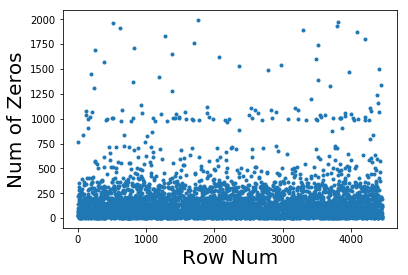

In [18]:
zz = np.zeros((NumRows_CV,1))
for ii in range(NumRows_CV):

    xx = np.array(rdt_t_prs_rlbl[rdt_t_prs_rlbl['ID']==rdt_t_prs_rlbl['ID'][ii]].drop(columns=['ID']))
    yy = xx[np.nonzero(xx)] #[xx[0,ii] for ii in range(xx.shape[1]) if xx[0,ii]>0]
    zz[ii] = len(yy)
plt.plot(zz,'.')
plt.xlabel('Row Num',fontsize=20)
plt.ylabel('Num of Zeros',fontsize=20)

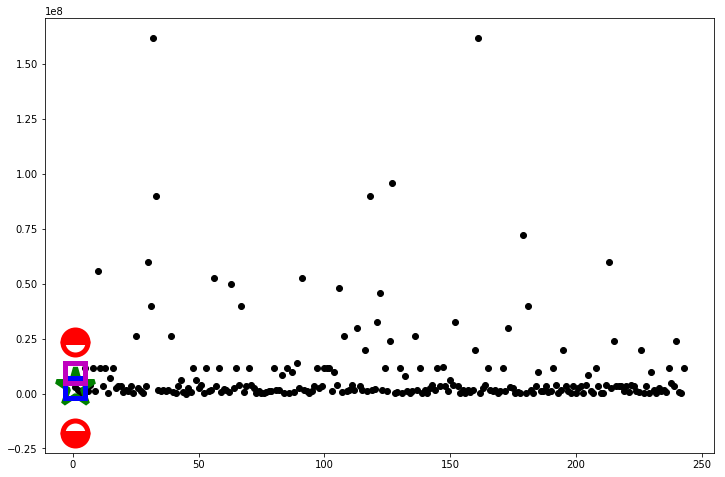

In [19]:
xx = np.array(rdt_t_prs_rlbl[rdt_t_prs_rlbl['ID']==rdt_t_prs_rlbl['ID'][1200]].drop(columns=['ID']))
yy = [xx[0,ii] for ii in range(xx.shape[1]) if xx[0,ii]>0]

plt.figure(figsize=[12,8])
plt.plot(np.linspace(1, len(yy), len(yy)), yy, 'ko')
plt.plot(np.linspace(1, 1, 1) ,yy[0], 'g*' , markersize=40, fillstyle='none', mew=5)
plt.plot(np.linspace(1, 1, 1) ,np.median(yy),'bs' , markersize=20, fillstyle='none', mew=5)
plt.plot(np.linspace(1, 1, 1) ,np.mean(yy),  'ms' , markersize=20, fillstyle='none', mew=5)
#plt.plot(np.linspace(1, 1, 1) ,np.std(yy),   'yd' , markersize=20, fillstyle='none', mew=5)
plt.plot(np.linspace(1, 1, 1) ,np.median(yy)+1*np.std(yy), 'ro' , markersize=25, fillstyle='top', mew=5)
plt.plot(np.linspace(1, 1, 1) ,np.median(yy)-1*np.std(yy), 'ro' , markersize=25, fillstyle='bottom', mew=5)
#plt.plot(np.linspace(1, 1, 1) ,np.median(yy)+1*stats.skew(yy), 'ro' , markersize=25, fillstyle='left', mew=5)
#plt.plot(np.linspace(1, 1, 1) ,np.median(yy)-1*stats.skew(yy), 'ro' , markersize=25, fillstyle='right', mew=5)

In [20]:
zz = pd.DataFrame(np.array(yy)).describe()
zz

,0
count,2.430000e+02
mean,9.531095e+06
std,2.074684e+07
min,2.000000e+04
25%,1.000000e+06
50%,2.730000e+06
75%,1.000000e+07
max,1.620000e+08


In [21]:
(zz.loc['75%'][0] + 1.0*(zz.loc['75%'][0] - zz.loc['25%'][0]))/1e6


19.0

In [22]:
zz.loc['max'][0]/1e6

162.0

# Peform any necessary operations on the label column 

In [23]:
# Python
# Drop the original target (label) column and add the log(target)
rdt_t_prs = rdt_t_prs_rlbl.drop('target', axis=1)
rdt_t_prs['logTarget'] = np.log1p(rdt_t_prs_rlbl.target)


# Spark 
# Drop the original target (label) column and add the log(target)
#S_rdt_t_prs = S_rdt_t_prs_rlbl.withColumn('logTarget',fcn.log1p(S_rdt_t_prs_rlbl.target)).drop('target')
#S_rdt_t_prs.printSchema()

# Identify universal aliases for Index and Label columns 


In [24]:
LBL = 'logTarget'
IDX = 'ID'

# ===========================

# Handle Datetime 

# ===========================

In [25]:
# There is note date column. So the dataframes just transfer as they are with no change 
# The subscript 't' (for time) will be dropped. 

# Python ======================
# CV Set ------------
rdt_prs   = rdt_t_prs
# Test Set ----------
rdt_T_prs = rdt_T_t_prs
# =============================
#
#
# Spark =======================
# CV Set --------------
#S_rdt_prs = S_rdt_t_prs
# Test Set ------------ 
#S_rdt_T_prs = S_rdt_T_t_prs
# =============================


# Remove parasitic columns

In [26]:
# CV Set
selec_lst   = list (set(rdt_prs.columns)  - set(clms_drop_list ))   # List of acceptable columns
#selec_lst   = list (set(rdt_prs.columns))   # List of acceptable columns


# Python
rdt = rdt_prs[selec_lst]
# Spark
#S_rdt = S_rdt_prs.select(selec_lst)


# ==================================================================================================


# Test Set
selec_T_lst = list (set(rdt_T_prs.columns)  - set(clms_drop_list ))
#selec_T_lst = list (set(rdt_T_prs.columns))


# Python
rdt_T     = rdt_T_prs[selec_T_lst]
# Spark
#S_rdt_T   = S_rdt_T_prs.select(selec_T_lst)

In [27]:
rdt.shape

(4459, 4737)

In [28]:
rdt_T.shape

(49342, 4736)

# Get the null statistics for every column 

In [29]:
# Pandas
# There are no nulls or na's in the dataframe 
print(sum(rdt.isnull().sum()!=0))
print(sum(rdt.isna().sum() !=0))

0
0


# Full fataframes with replaced null values

In [40]:
# Since there are no Null values, rdt transfers directly to fdt 

# Python 
fdt = rdt
fdt_T = rdt_T


# Spark
#S_fdt = S_rdt
#S_fdt_T = S_rdt_T


# Since this is sparse matrix, get the percentage of 0's for every column

In [55]:
# Python 
# Calculate the percentage of 0's per column in the dataframe 

Sparsity_per_col = (rdt == 0).astype(int).sum(axis=0)/NumRows_CV
#Sparsity_per_col = (rdt_T == 0).astype(int).sum(axis=0)/NumRows_T


In [56]:
print(Sparsity_per_col.shape)
print(len(rdt.columns))

(4736,)
4736


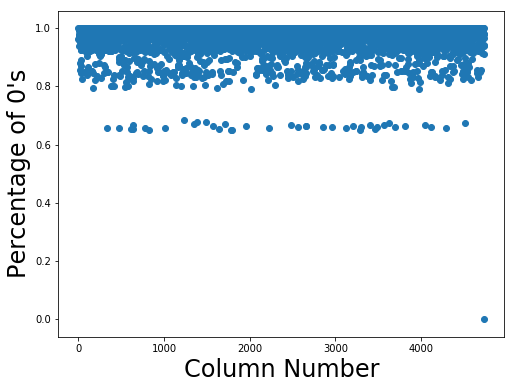

In [57]:
# Visualize the sparsity 
plt.figure(figsize=(8,6))

plt.scatter(np.linspace(0,len(rdt.columns),len(rdt.columns)), Sparsity_per_col)

plt.xlabel('Column Number', {'Fontsize': 24})
plt.ylabel("Percentage of 0's", {'Fontsize': 24})
plt.show()



# Rename the processed dataframe | Rename the label col | Drop the index 

In [59]:
# CV Set 

# Python 
Xy = fdt 
#Xy['Labels'] = fdt['logTarget']
#Xy.drop('logTarget', axis=1, inplace= True)
#Xy.drop('ID', axis = 1, inplace= True)

# Spark
#S_Xy = S_fdt.withColumnRenamed(LBL,'Labels').drop('logTarget')
#S_Xy = S_Xy.drop('ID')


# ==============================================================================
# Test Set (No Labels)

# Python 
X = fdt_T.drop('ID', axis = 1)

# Spark
#S_X = S_fdt_T.drop('Id')


# Train/Test data

In [60]:
X_train = Xy.drop('Labels', axis=1).apply(np.log1p)
y_train = Xy['Labels']

X_test = X.apply(np.log1p)

In [61]:
print(X_train.shape)
print(X_test.shape)

(4459, 4735)
(49342, 4735)


# Divide the samples based on their number of zeros 

In [62]:
NonZeroCounts_train = pd.Series()
NonZeroCounts_train['non_zero_count'] = (X_train).fillna(0).astype(bool).sum(axis=1) 

NonZeroCounts_test = pd.Series()
NonZeroCounts_test['non_zero_count'] = (X_test).fillna(0).astype(bool).sum(axis=1) 

Text(0.5, 0, 'Sample Number')

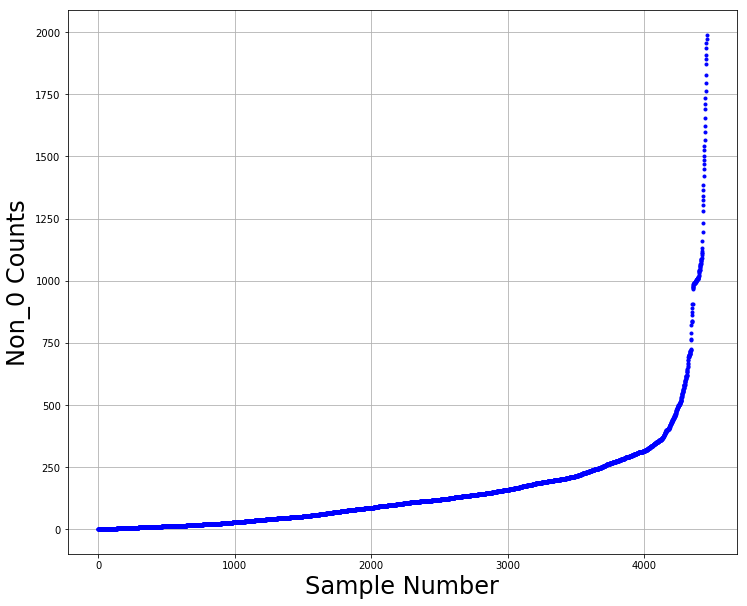

In [63]:
plt.figure(figsize=(12,10))
Vec = NonZeroCounts_train['non_zero_count'].sort_values().values
plt.plot(Vec,'b.')
plt.grid('ON')
plt.ylabel('Non_0 Counts',{'fontsize' : 24})
plt.xlabel('Sample Number', {'fontsize' : 24})
#plt.ylim((0,250))

In [64]:
thresh = 200

NonZeroCount_Filtered_idx_train_below = NonZeroCounts_train['non_zero_count'][NonZeroCounts_train['non_zero_count']<thresh].index

Zert = NonZeroCounts_train['non_zero_count'][NonZeroCounts_train['non_zero_count']>100].index
#NonZeroCount_Filtered_idx_train_below = pd.Series(list(set(Zert) & set(NonZeroCount_Filtered_idx_train_below))).index

X_train_SubBelow = X_train.iloc[NonZeroCount_Filtered_idx_train_below]
y_train_SubBelow = y_train.iloc[NonZeroCount_Filtered_idx_train_below]

# --------------------------------------------------------------
NonZeroCount_Filtered_idx_train_above = NonZeroCounts_train['non_zero_count'][NonZeroCounts_train['non_zero_count']>=thresh].index
X_train_SubAbove = X_train.iloc[NonZeroCount_Filtered_idx_train_above]
y_train_SubAbove = y_train.iloc[NonZeroCount_Filtered_idx_train_above]



#======================================================================
NonZeroCount_Filtered_idx_test_below = NonZeroCounts_test['non_zero_count'][NonZeroCounts_test['non_zero_count']<thresh].index
X_test_SubBelow = X_test.iloc[NonZeroCount_Filtered_idx_test_below]
# -------------------------------------------------------------
NonZeroCount_Filtered_idx_test_above = NonZeroCounts_test['non_zero_count'][NonZeroCounts_test['non_zero_count']>=thresh].index
X_test_SubAbove = X_test.iloc[NonZeroCount_Filtered_idx_test_above]

#y_test = y_test.iloc[NonZeroCount_Filtered_idx_test]


In [65]:
print(X_train.shape[0])
print(X_train_SubBelow.shape[0])
print(X_train_SubAbove.shape[0])

print('\n')
print(X_test.shape[0])
print(X_test_SubBelow.shape[0])
print(X_test_SubAbove.shape[0])

4459
3377
1082


49342
45717
3625



# Select features based on their importances for descriptive statistics

In [66]:
%%time
# Fit a standard random forest
model = PythonRF_Regressor(n_estimators=10, random_state=42)
#model.fit(X_train, y_train)
model.fit(X_train_SubAbove, y_train_SubAbove)
#model.fit(X_train_SubBelow, y_train_SubBelow)
FIM = model.feature_importances_

Wall time: 5.55 s


In [68]:
#np.nonzero(FIM)[0]
clms_for_stats = X_train.columns[INDEX_for_Stats]
X_train_for_stats = X_train[clms_for_stats] 
X_test_for_stats  = X_test[clms_for_stats] 
print(X_train_for_stats.shape)
print(X_test_for_stats.shape)


X_train_SubAbove_for_stats = X_train_SubAbove[clms_for_stats]
X_train_SubBelow_for_stats = X_train_SubBelow[clms_for_stats]

print(X_train_SubAbove_for_stats.shape)
print(X_train_SubBelow_for_stats.shape)


(4459, 3927)
(49342, 3927)
(1082, 3927)
(3377, 3927)


# Unify the distributions between train and test sets 

In [69]:
THRESHOLD_P_VALUE = 0.05 #need tuned       # same results with 0.01 
THRESHOLD_STATISTIC = 0.2 #need tuned      # same results with 0.3
diff_cols = []
for col in X_train.columns:
    statistic, pvalue = ks_2samp(X_train[col].values, X_test[col].values)
    if pvalue <= THRESHOLD_P_VALUE and np.abs(statistic) > THRESHOLD_STATISTIC:
        diff_cols.append(col)
for col in diff_cols:
    if col in X_train.columns:
        X_train.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)

print(X_train.shape)
print(X_test.shape)

(4459, 4717)
(49342, 4717)


# Compute threshold for outlier removal

In [70]:
%%time
Quartile_Units = 1.5
Thresholds = np.zeros((NumRows_CV,))
#zz.apply(stats.describe(nan_policy='omit'), axis=1)

X_train_reset = np.zeros((X_train.shape[0], X_train.shape[1]))
for idx in range(X_train.shape[0]):
    #print(idx)
    xx = np.array(X_train.iloc[idx])
    #yy = pd.DataFrame([xx[ii] for ii in range(xx.shape[0]) if xx[ii]>0])
    yy  = pd.DataFrame(xx[np.nonzero(xx)]) 
    STATS = yy.describe()    
    Thresholds[idx] = STATS.loc['75%'][0] + Quartile_Units*(STATS.loc['75%'][0] - STATS.loc['25%'][0])
    yy.where(yy<Thresholds[idx], 0, inplace=True)
    xx[np.nonzero(xx)] = np.array(yy).reshape(yy.shape[0],)
    
    X_train_reset[idx,:] = xx
    
Thresholds

Wall time: 27.4 s


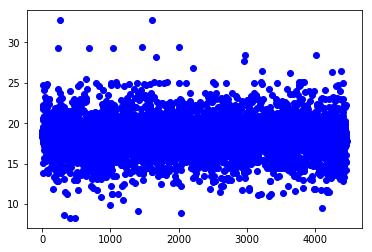

In [71]:
plt.plot(np.linspace(1,len(Thresholds), len(Thresholds)),Thresholds,'bo')

In [72]:
clm_list  = X_train.columns
X_train = pd.DataFrame(X_train_reset)
X_train.columns = clm_list

# Feature engineering

In [89]:
%%time
def prepare(data_orig):
    
    data = pd.DataFrame()
    
    
    data['mean'] = (data_orig).mean(axis=1)
    data['med']  = (data_orig).median(axis=1)
    data['std']  = (data_orig).std(axis=1)
    data['std%'] = (data_orig).std(axis=1)/data['mean']*100
    data['skew'] = (data_orig).skew(axis=1)
    data['kurt'] = (data_orig).kurtosis(axis=1)
    data['min']  = (data_orig).min(axis=1)
    data['max']  = (data_orig).max(axis=1) +1e-4
    #data['range']  = (data_orig).max(axis=1) +1e-4 - data['min']
    data['number_of_different'] = (data_orig).nunique(axis=1)               # Number of different values in a row.
    data['non_zero_count'] = (data_orig).fillna(0).astype(bool).sum(axis=1) # Number of non zero values (e.g. transaction count)
    data['sum']  = (data_orig).sum(axis=1) # Number of non zero values (e.g. transaction count)
    

        
    data['med'].replace(np.nan,np.nanmedian(data['med']), inplace =True)
    data['mean'].replace(np.nan,np.nanmedian(data['mean']), inplace =True)
    
    
    #for ii in range(len(data['med'])):
    #    if data['non_zero_count'][ii] < 5:
    #        data['med'].iloc[ii] = np.median(data['med'])
    '''
    data['mean_p_std']  = data['mean'] + data['std']
    data['mean_m_std']  = data['mean'] - data['std']    
    data['mean_p_hstd']  = data['mean'] + 0.5*data['std']
    data['mean_m_hstd']  = data['mean'] - 0.5*data['std']

    
    data['med_p_std']  = data['med'] + data['std']
    data['med_m_std']  = data['med'] - data['std']    
    data['med_p_hstd']  = data['med'] + 0.5*data['std']
    data['med_m_hstd']  = data['med'] - 0.5*data['std']
    '''

    return data

# Replace 0 with NaN to ignore them

X_train_add = prepare(X_train_for_stats.replace(0, np.nan)).replace(np.nan,0)
X_test_add  = prepare(X_test_for_stats.replace(0, np.nan)).replace(np.nan,0)


#X_train_add = prepare(X_train_for_stats.replace(0, np.nan)).replace(np.nan,0)
#X_train_add = prepare(X_train_SubAbove_for_stats.replace(0, np.nan)).replace(np.nan,0)
#X_train_add = prepare(X_train_SubBelow_for_stats.replace(0, np.nan)).replace(np.nan,0)

#X_test_add  = prepare(X_test.replace(0, np.nan)).replace(np.nan,0)


Wall time: 1min 12s


In [80]:
print(y_train.median() , y_train.mean() )


14.630875813726247 14.490239292748658


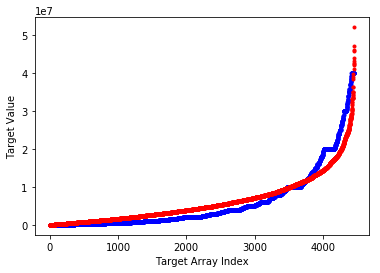

In [81]:
plt.plot(np.linspace(1,len(y_train.sort_values()), len(y_train.sort_values())), np.expm1(y_train.sort_values()),'b.')


ExpDist = np.random.exponential(scale=6.25e6, size = len(y_train.sort_values()))
plt.plot(np.linspace(1,len(y_train.sort_values()), len(y_train.sort_values())), np.sort(ExpDist) ,'r.')


#stats.probplot(y_train, plot=plt)
#stats.probplot(rdt_t_prs_rlbl['target'] , plot=plt)

plt.xlabel('Target Array Index')
plt.ylabel('Target Value')
plt.show()


In [91]:
print(sum(X_train.sum(axis=1)==0))
print(sum(X_test.sum(axis=1)==0))

130
72


In [92]:
print(np.min(sum(X_train.sum(axis=0))))
print(np.min(sum(X_test.sum(axis=0
                           ))))

9384723.765682196
47459296.25772015



# Augment the data set with aggregated features 

In [93]:
X_train_aug = pd.concat([X_train, X_train_add], axis=1)
X_test_aug  = pd.concat([X_test, X_test_add], axis=1)

In [94]:
print(X_train_aug.shape)
print(X_test_aug.shape)

(4459, 4728)
(49342, 4728)


# Apply Dimensionality Reduction

In [362]:
sc  = StandardScaler()
mM  = MinMaxScaler()
pca = PCA(n_components=400).fit_transform(mM.fit_transform(X_train_for_stats))
#grp = GRM(n_components=100).fit_transform(mM.fit_transform(X_train_for_stats))

#svd = TruncatedSVD(n_components=2000, algorithm='randomized', n_iter=20).fit(X_train)
#fca  = FactorAnalysis().fit(X_train) 

In [363]:
X_train_aug_PCA = pd.concat([X_train_aug, pd.DataFrame(pca)], axis=1)

In [364]:
X_train_aug_PCA.shape

(4459, 5404)

In [382]:
#print(pca.explained_variance_ratio_)

In [236]:
print(svd.explained_variance_ratio_)

[  5.24364695e-02   3.45143405e-02   3.45176725e-02 ...,   3.45971665e-06
   3.44263725e-06   3.41653869e-06]


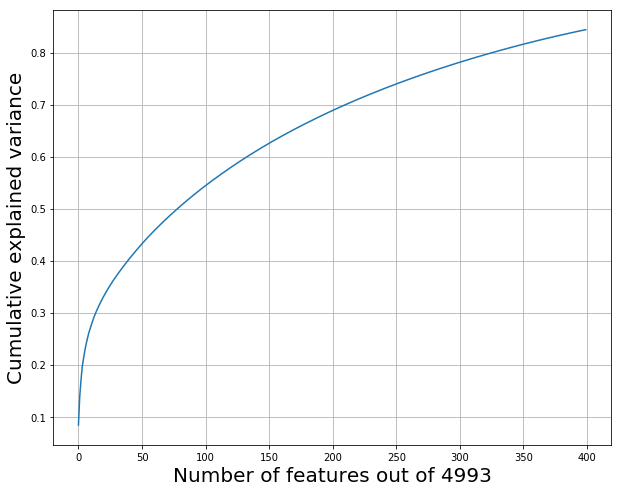

In [360]:
plt.figure(figsize=(10,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.plot(np.cumsum(svd.explained_variance_ratio_))

plt.xlabel('Number of features out of 4993', {'fontsize': 20})
plt.ylabel('Cumulative explained variance', {'fontsize': 20})
#plt.xlim((0,1500))
#plt.ylim((0.98,1))

plt.grid()

In [239]:
#X_train_PCA = PCA(n_components=2000,whiten=False).fit_transform(X_train)
#X_test_PCA  = PCA(n_components=2000,whiten=False).fit_transform(X)

X_train_tSVD = TruncatedSVD(n_components=1250).fit_transform(X_train)
#X_test_tSVD  = TruncatedSVD(n_components=1250).fit_transform(X)


print('Finished @', dt.datetime.now())

Finished @ 2018-07-03 13:52:18.568790


# Parameter Grids and the Models

In [95]:
# Define the search grid

# Work in progress

XGBparams = {'objective': ['reg:linear'],
             'n_estimators': [1000],
             'learning_rate': [0.01],
             'max_depth': [20],
             'min_child_weight': [57],
             'gamma' : [0.45],
             'reg_alpha': [0.0],
             'reg_lambda': [0.0],
             'subsample': [0.67],
             'nthread': [-1],
             }


#BaseLine
RFparams = {'n_estimators'    : [200],
            'min_samples_leaf': [2], 
            'max_leaf_nodes'  : [100],
            'n_jobs'          : [-1],
            #'random_state'    : [42],
            #'oob_score'       : [True],
            #'warm_start'       : [True],
            'max_features'    : [0.7],
             }


'''
XGBparams = {'objective': ['reg:linear'],
             'n_estimators': [1000],
             'learning_rate': [0.02],
             'max_depth': [22],
             'min_child_weight': [57],
             'gamma' : [1.45],
             'reg_alpha': [0.0],
             'reg_lambda': [0.0],
             'subsample': [0.67],
             'colsample_bytree': [0.054], #0.054
             'colsample_bylevel': [0.50],
             'nthread': [-1],
             }
'''

# Define the models using the parameter grids

mdl_RF  = PythonRF_Regressor()#.set_params(**RFparams)
mdl_XGB = XGBRegressor()#.set_params(**XGBparams)

# Fit the model through cross validation

### RF

In [96]:
%%time 

# define the model
model = GridSearchCV(estimator  = mdl_RF,
                     param_grid = RFparams,
                     scoring    ='neg_mean_squared_error',
                     cv=10)

# Fit Grid Search Model
mdl_RF_fitted = model.fit(X_train_add, y_train)
#mdl_RF_fitted = model.fit(X_train_add, y_train_SubAbove)
#mdl_RF_fitted = model.fit(X_train_add, y_train_SubBelow)



print("params:\n")
print(model.cv_results_.__getitem__('params'))
print("mean test scores:")
print(np.sqrt(model.cv_results_.__getitem__('mean_test_score')*-1))
print('\n')
print("std test scores:")
print((model.cv_results_.__getitem__('std_test_score'))**2 )
print('\n')
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:", model.best_params_)
print("**********************************************")



params:

[{'max_features': 0.7, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}]
mean test scores:
[1.39307592]


std test scores:
[0.03754997]


Best score: -1.941
Best parameters set: {'max_features': 0.7, 'max_leaf_nodes': 100, 'min_samples_leaf': 2, 'n_estimators': 200, 'n_jobs': -1}
**********************************************
Wall time: 20.8 s


In [156]:
zz = pd.DataFrame(y_pred)
zz.corr()

,0,1,2,3,4
0,1.000000,0.996660,0.996709,0.996865,0.996973
1,0.996660,1.000000,0.996764,0.996689,0.996515
2,0.996709,0.996764,1.000000,0.996861,0.996632
3,0.996865,0.996689,0.996861,1.000000,0.996869
4,0.996973,0.996515,0.996632,0.996869,1.000000


# Submission 

In [322]:
RF_SubBelow_pred = mdl_RF_fitted.best_estimator_.predict(X_train_add_SubBelow)  
RF_SubAbove_pred = mdl_RF_fitted.best_estimator_.predict(X_train_add_SubAbove)  


print(np.sqrt(mean_squared_error(RF_SubBelow_pred, y_train_SubBelow)))
print(np.sqrt(mean_squared_error(RF_SubAbove_pred, y_train_SubAbove)))



1.11251182725
1.15438586882


In [464]:
#mdl_RF_fitted         = pickle.load(open('RF_Model.sav', 'rb'))
RF_submission          = mdl_RF_fitted.best_estimator_.predict(X_test_aug)

In [465]:
Submission            = pd.DataFrame(columns=['ID', 'target'])
Submission['ID']      = fdt_T['ID']
Submission['target']  = np.expm1(RF_submission)
Submission.to_csv('RF_OrigF_P_Stats_wlog1p_Behtash.csv', index=False)

### XGBoost

In [76]:
%%time 
# define the model
model = GridSearchCV(estimator = mdl_XGB,
                     param_grid = XGBparams,
                     scoring='neg_mean_squared_error',
                     cv=10)

# Fit Grid Search Model
# mdl_XGB_fitted = model.fit(X_train_add, y_train)
mdl_XGB_fitted = model.fit(X_train_add, y_train_SubAbove)
print("params:\n")
print(model.cv_results_.__getitem__('params'))
print("mean test scores:\n")
print(np.sqrt(model.cv_results_.__getitem__('mean_test_score')*-1))
print("std test scores:\n")
print((model.cv_results_.__getitem__('std_test_score'))**2)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:", model.best_params_)
print("**********************************************")

params:

[{'gamma': 0.45, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 57, 'n_estimators': 1000, 'nthread': -1, 'objective': 'reg:linear', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.67}]
mean test scores:

[ 1.39613472]
std test scores:

[ 0.06543091]
Best score: -1.949
Best parameters set: {'gamma': 0.45, 'learning_rate': 0.01, 'max_depth': 20, 'min_child_weight': 57, 'n_estimators': 1000, 'nthread': -1, 'objective': 'reg:linear', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.67}
**********************************************
Wall time: 34.6 s


In [163]:
filename = 'XGB_Model.sav'
pickle.dump(mdl_XGB_fitted, open(filename, 'wb'))

# Submission

In [387]:
#X = X[X_train.columns]
#mdl_XGB_fitted         = pickle.load(open('XGB_Model.sav', 'rb'))
XGB_submission           = mdl_XGB_fitted.predict(X_test_aug)

In [388]:
Submission            = pd.DataFrame(columns=['ID', 'target'])
Submission['ID']      = fdt_T['ID']
Submission['target']  = (np.expm1(XGB_submission) + np.expm1(RF_submission))/2
Submission.to_csv('AVG_RF_XGB_FeaturesOrigPlus10_Behtash.csv', index=False)

In [384]:
test = pd.DataFrame(columns=['RF','XGB'])
test['RF']  = np.expm1(RF_submission)
test['XGB'] = np.expm1(XGB_submission)
test.corr()

,RF,XGB
RF,1.000000,0.837147
XGB,0.837147,1.000000


# Random Forest find cross-val scores

In [105]:
'''
%time RF_scores = cross_val_score(mdl_RF, X = X_train, y = y_train, cv=10, scoring = 'neg_mean_squared_error' )
print('Finished @', dt.datetime.now())
pd.DataFrame((np.sqrt(-1*RF_scores))).describe()
'''

"\n%time RF_scores = cross_val_score(mdl_RF, X = X_train, y = y_train, cv=10, scoring = 'neg_mean_squared_error' )\nprint('Finished @', dt.datetime.now())\npd.DataFrame((np.sqrt(-1*RF_scores))).describe()\n"

# XGboost

In [104]:
'''
%time XGB_scores = cross_val_score(mdl_XGB, X = X_train, y =y_train, cv=10, scoring = 'neg_mean_squared_error' )
print('Finished @', dt.datetime.now())
pd.DataFrame((np.sqrt(-1*XGB_scores))).describe()
'''

"\n%time XGB_scores = cross_val_score(mdl_XGB, X = X_train, y =y_train, cv=10, scoring = 'neg_mean_squared_error' )\nprint('Finished @', dt.datetime.now())\npd.DataFrame((np.sqrt(-1*XGB_scores))).describe()\n"